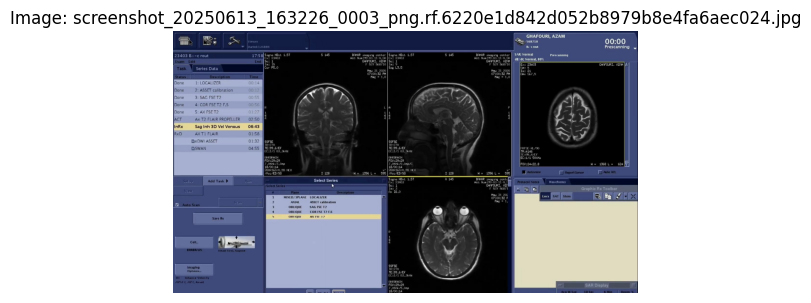

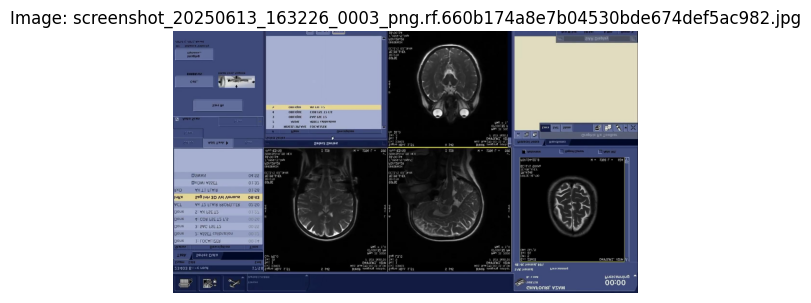

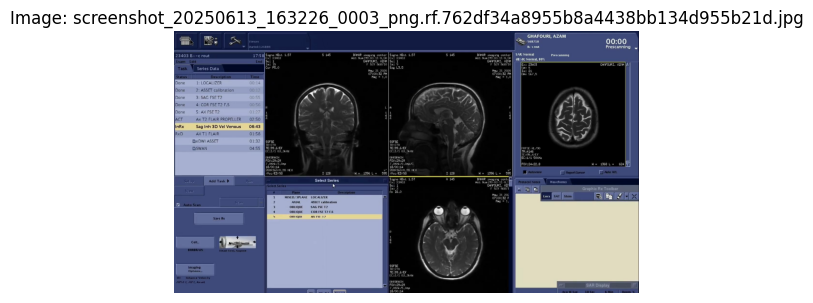

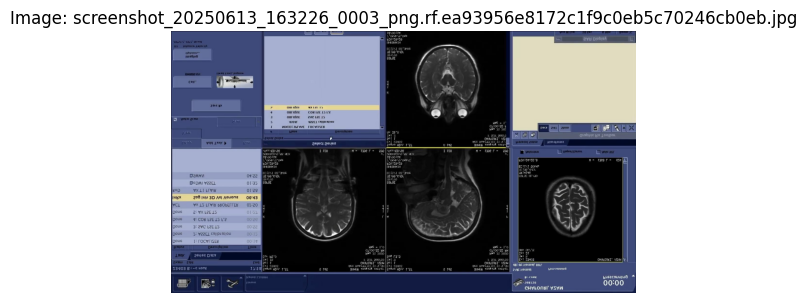

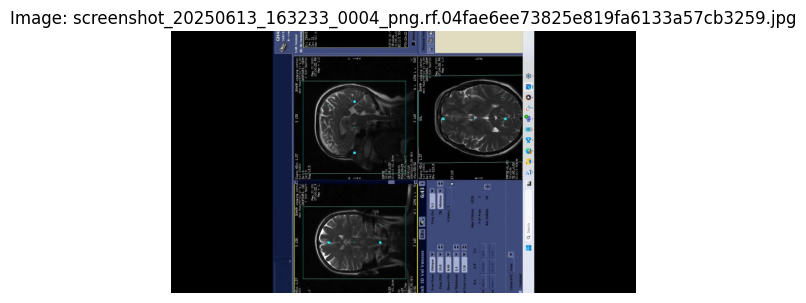

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to your image folder
image_folder = "data/train/images"

# List all image files (you can filter for .jpg, .png, etc.)
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Load and display the first few images
for i, img_name in enumerate(image_files[:5]):  # Display first 5 images
    img_path = os.path.join(image_folder, img_name)
    image = Image.open(img_path).convert("RGB")

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Image: {img_name}")
    plt.axis('off')
    plt.show()


In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class YOLOTxtDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms

        self.image_files = sorted([
            f for f in os.listdir(images_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_filename)
        label_path = os.path.join(
            self.labels_dir, os.path.splitext(image_filename)[0] + ".txt"
        )

        image = Image.open(image_path).convert("RGB")
        width, height = image.size

        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center = float(parts[1]) * width
                    y_center = float(parts[2]) * height
                    box_width = float(parts[3]) * width
                    box_height = float(parts[4]) * height

                    x_min = x_center - box_width / 2
                    y_min = y_center - box_height / 2
                    x_max = x_center + box_width / 2
                    y_max = y_center + box_height / 2

                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(class_id)

        # Convert to tensors and ensure proper shape
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        if boxes.ndim == 1:
            boxes = boxes.unsqueeze(0)
        if labels.ndim == 0:
            labels = labels.unsqueeze(0)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.image_files)


In [3]:
import torchvision.transforms.functional as F

def letterbox(image, target_size=640):
    w, h = image.size
    scale = min(target_size / w, target_size / h)
    new_w, new_h = int(w * scale), int(h * scale)

    resized = F.resize(image, (new_h, new_w))
    pad_w = target_size - new_w
    pad_h = target_size - new_h
    padding = (pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2)
    padded = F.pad(resized, padding, fill=(114, 114, 114))

    return padded


In [4]:
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import ImageOps

def replicate_channels(image):
    if image.shape[0] == 1:
        image = image.repeat(3, 1, 1)  # [1, H, W] → [3, H, W]
    return image

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Lambda(replicate_channels),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Centered normalization
])


dataset = YOLOTxtDataset(
    images_dir="data/train/images",
    labels_dir="data/train/labels",
    transforms=transform
)

def collate_fn(batch):
    return tuple(zip(*batch))

dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)


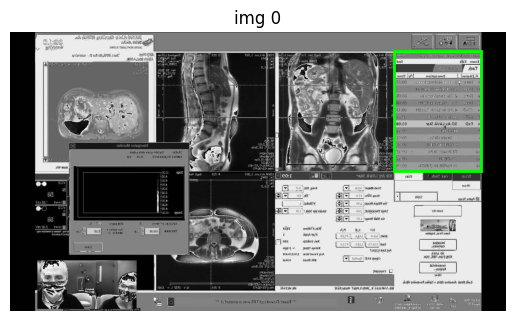

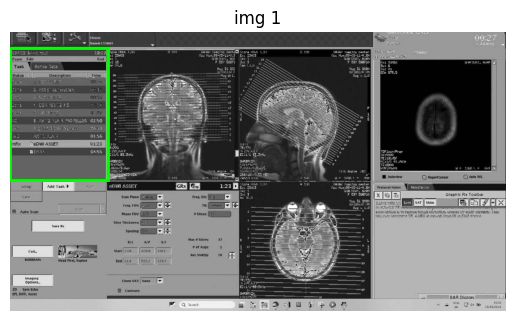

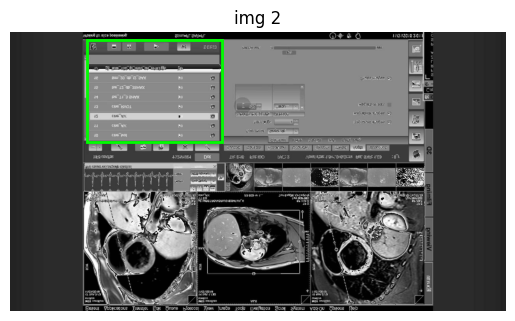

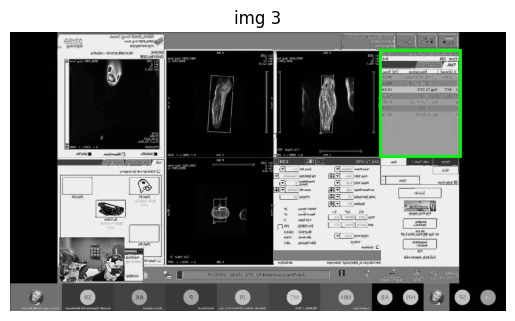

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F

# Pick one batch from your dataloader
images, targets = next(iter(dataloader))

# Loop through the batch
for i in range(len(images)):
    image = images[i]
    target = targets[i]

    # Convert tensor image to PIL for plotting
    img = F.to_pil_image(image)
    boxes = target['boxes']

    # Plot
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for box in boxes:
        if box.numel() != 4:
            continue  # Skip invalid or empty boxes
        x_min, y_min, x_max, y_max = box.tolist()
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)

    plt.title(f"img {i}")
    plt.axis('off')
    plt.show()


In [6]:
import sys
sys.path.append('./detr')  # Adjust path if needed
from models import build_model



import torch
print(torch.cuda.is_available())         # Should be True
print(torch.cuda.get_device_name(0))     # Should show your RTX 2000


True
NVIDIA RTX 2000 Ada Generation Laptop GPU


In [20]:
import torch
from models import build_model  # Assuming you've added `detr/` to sys.path

class Args:
    def __init__(self):
        # Model architecture
        self.backbone = 'resnet18'
        self.dilation = False
        self.position_embedding = 'sine'
        self.hidden_dim = 128
        self.num_queries = 10
        self.enc_layers = 2
        self.dec_layers = 2
        self.dim_feedforward = 512
        self.dropout = 0.1
        self.nheads = 8
        self.pre_norm = False
        self.aux_loss = True

        # Loss + Matcher
        self.set_cost_class = 1.0
        self.set_cost_bbox = 5.0
        self.set_cost_giou = 2.0
        self.bbox_loss_coef = 2.0
        self.giou_loss_coef = 1.0
        self.eos_coef = 0.1

        # Dataset setup
        self.dataset_file = 'custom'
        self.num_classes = 2   # 1 class + background

        # Backbone / device setup
        self.lr_backbone = 1e-5
        self.masks = False
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args = Args()
device = torch.device(args.device)

model, criterion, postprocessors = build_model(args)
model.to(device)

# Freeze all backbone parameters
for param in model.backbone.parameters():
    param.requires_grad = False


c:\Users\z00511dv\Downloads\DLproj\project_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\z00511dv\Downloads\DLproj\project_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
print(targets[3]['boxes'][:3])



tensor([[1470.,  281., 1823.,  910.]], device='cuda:0')


In [22]:
torch.cuda.empty_cache()


In [24]:
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import time

# 🎯 Set up
model.train()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-4)
scaler = GradScaler(device="cuda")
writer = SummaryWriter(log_dir="runs/detr_training")

num_epochs = 10

for epoch in range(num_epochs):
    epoch_start = time.time()
    total_loss = 0.0

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    pbar = tqdm(dataloader, desc="Training", leave=False)

    for batch_idx, (images, targets) in enumerate(pbar):
        # 🧼 Skip batches with no boxes
        if any(t['boxes'].numel() == 0 for t in targets):
            continue

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        global_step = epoch * len(dataloader) + batch_idx

        optimizer.zero_grad()

        with autocast("cuda"):
            outputs = model(images)
            loss_dict = criterion(outputs, targets)
            loss = sum(loss for loss in loss_dict.values())

        # ⚖️ Scaled mixed precision step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # ⏺️ Logging individual loss components
        for k, v in loss_dict.items():
            writer.add_scalar(f"Loss/{k}", v.item(), global_step)

        writer.add_scalar("Loss/total", loss.item(), global_step)

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    epoch_time = time.time() - epoch_start
    avg_epoch_loss = total_loss / len(dataloader)
    writer.add_scalar("Epoch/Loss", avg_epoch_loss, epoch)

    print(f"Epoch {epoch+1} completed — Loss: {total_loss:.4f} | Time: {epoch_time:.1f} sec")

    torch.cuda.empty_cache()

# ✅ Save model
torch.save(model.state_dict(), "detr_final.pth")
writer.close()



Epoch [1/10]


Epoch 1 completed — Loss: 5428238.2607 | Time: 576.1 sec

Epoch [2/10]


Epoch 2 completed — Loss: 5421052.8342 | Time: 625.5 sec

Epoch [3/10]


Epoch 3 completed — Loss: 5355542.7158 | Time: 1312.6 sec

Epoch [4/10]


Epoch 4 completed — Loss: 5359380.7246 | Time: 1884.4 sec

Epoch [5/10]


Epoch 5 completed — Loss: 5538194.0837 | Time: 757.3 sec

Epoch [6/10]


Epoch 6 completed — Loss: 5441503.4563 | Time: 699.9 sec

Epoch [7/10]


KeyboardInterrupt: 

In [2]:
from engine import train_one_epoch
from models import build_model
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 👷 Build model
model, criterion, postprocessors = build_model(args)
model.to(device)

# ⚙️ Optimizer
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)

# 🔁 Training loop
for epoch in range(num_epochs):
    train_stats = train_one_epoch(
        model, criterion, dataloader, optimizer, device, epoch,
        max_norm=0.1  # gradient clipping
    )


ModuleNotFoundError: No module named 'engine'